<a href="https://colab.research.google.com/github/dbetm/DeepLearningLifeSciences/blob/main/Cell_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Cell segmentation**: The task of cellular segmentation involves annotating a given cellular microscopy
image to denote where cells appear and where background appears.

Segmentation masks provide significantly finer-grained resolution and permit for more refined analysis than cell counting. For example, it might be useful to understand what fraction of a given plate is covered with cells.

**Dataset**: [BBBC005](https://bbbc.broadinstitute.org/BBBC005) (synthetic data).

## Setup

In [ ]:
# !curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
# import conda_installer
# conda_installer.install()
!/root/miniconda/bin/conda info -e
!pip install --pre deepchem
import deepchem as dc
dc.__version__

## Loading dataset

In [ ]:
# Downloading the images (1.8 GB, 3-10 minutes)
!wget https://data.broadinstitute.org/bbbc/BBBC005/BBBC005_v1_images.zip
!unzip BBBC005_v1_images.zip

In [ ]:
# Downloading ground-truth (10 MB), because each 'label' is itself an image.
!wget https://data.broadinstitute.org/bbbc/BBBC005/BBBC005_v1_ground_truth.zip
!unzip BBBC005_v1_ground_truth.zip

In [3]:
import os

import numpy as np

In [4]:
image_dir = 'BBBC005_v1_images'
label_dir = 'BBBC005_v1_ground_truth'

rows = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P')
blurs = (1, 4, 7, 10, 14, 17, 20, 23, 26, 29, 32, 35, 39, 42, 45, 48)
files = []
labels = []

for f in os.listdir(label_dir):
  if f.endswith('.TIF'):
    for row, blur in zip(rows, blurs):
      fname = f.replace('_F1', '_F%d'%blur).replace('_A', '_%s'%row)
      files.append(os.path.join(image_dir, fname))
      labels.append(os.path.join(label_dir, f))
      
dataset = dc.data.ImageDataset(files, labels)

In [5]:
splitter = dc.splits.RandomSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
  dataset=dataset,
  seed=123
)

print('Training dataset shape: {}'.format(train_dataset))
print('Validation dataset shape: {}'.format(valid_dataset))
print('Test dataset shape: {}'.format(test_dataset))

Training dataset shape: <ImageDataset X.shape: [15360   520   696], y.shape: [15360   520   696], w.shape: (15360, 1), task_names: [  0   1   2 ... 517 518 519]>
Validation dataset shape: <ImageDataset X.shape: [1920  520  696], y.shape: [1920  520  696], w.shape: (1920, 1), task_names: [  0   1   2 ... 517 518 519]>
Test dataset shape: <ImageDataset X.shape: [1920  520  696], y.shape: [1920  520  696], w.shape: (1920, 1), task_names: [  0   1   2 ... 517 518 519]>


## Model - U-Net

The architecture [U-Net](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) does well (fast and precise) at the task of image segmentation.

The U-Net architecture uses a stacked series of convolutions to progressively "downsample" and then "upsample" the source image.

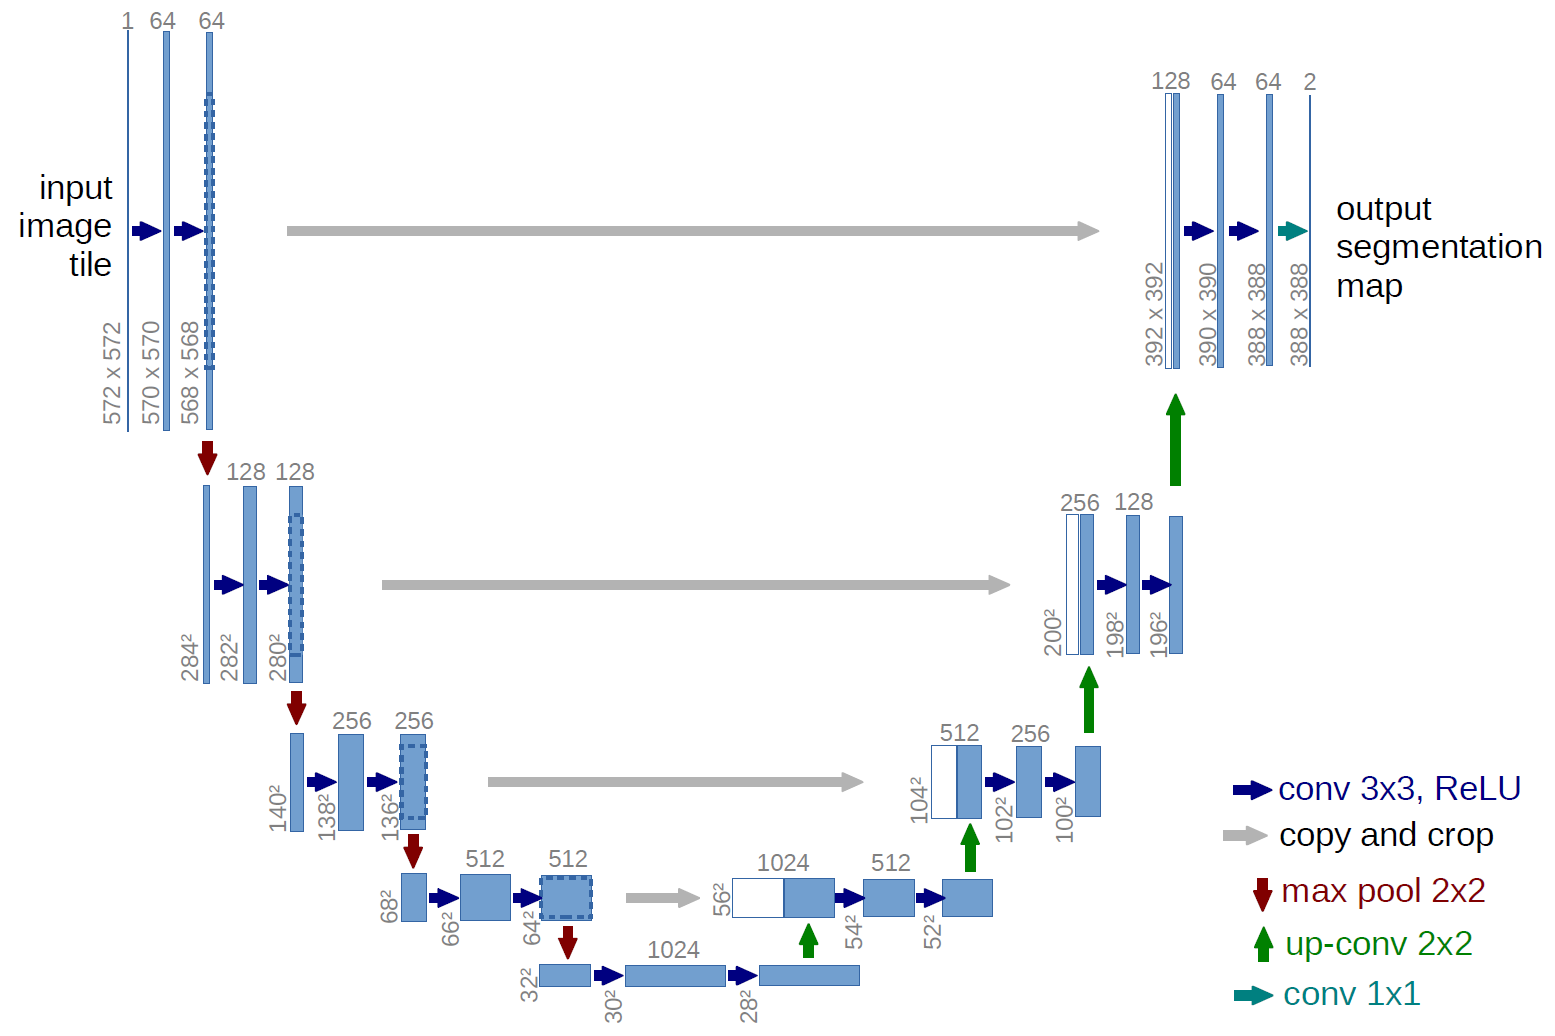

In [6]:
import tensorflow as tf
import tensorflow.keras.layers as layers

In [40]:
input_shape = (520, 696, 1)
batch_size = 32

optimizer = dc.models.optimizers.ExponentialDecay(initial_rate=0.0001, decay_rate=0.4, decay_steps=250)

In [43]:
# Building the model
input = tf.keras.Input(shape=input_shape)
# Downsample 3 times - encoder
conv1 = layers.Conv2D(16, kernel_size=5, strides=2, activation='relu', padding='same')(input/255.0)
conv2 = layers.Conv2D(32, kernel_size=5, strides=2, activation='relu', padding='same')(conv1)
conv3 = layers.Conv2D(64, kernel_size=5, strides=2, activation='relu', padding='same')(conv2)

# Do a 1x1 convolution
conv4 = layers.Conv2D(filters=64, kernel_size=1, strides=1)(conv3)
# Upsample 3 times - decoder
concat1 = layers.Concatenate(axis=3)([conv3, conv4])
deconv1 = layers.Conv2DTranspose(filters=32, kernel_size=5, strides=2, activation='relu', padding='same')(concat1)
concat2 = layers.Concatenate(axis=3)([conv2, deconv1])
deconv2 = layers.Conv2DTranspose(filters=16, kernel_size=5, strides=2, activation='relu', padding='same')(concat2)
concat3 = layers.Concatenate(axis=3)([conv1, deconv2])
deconv3 = layers.Conv2DTranspose(filters=1, kernel_size=5, strides=2, activation='relu', padding='same')(concat3)
# output
concat4 = layers.Concatenate(axis=3)([input, deconv3])
logits = layers.Conv2D(filters=1, kernel_size=5, strides=1, padding='same')(concat4)
output = layers.Activation(activation='sigmoid')(logits)

# keras model
keras_model = tf.keras.Model(inputs=input, outputs=[output, logits])

model = dc.models.KerasModel(
  model=keras_model,
  loss=dc.models.losses.SigmoidCrossEntropy(),
  output_types=['prediction', 'loss'],
  learning_rate=optimizer,
  tensorboard=True
)

## Training

**Note**: If you don't want to train the model, you can get a pre-trained model [here](https://s3-us-west-1.amazonaws.com/deepchem.io/featurized_datasets/microscopy_models.zip), and then load with `model.restore()` (you need to specify model directory when you instance the model). **Please, check the next section.**

You also can use the next code in order to download the weights of the trained model:

```
mkdir models
cd models
wget https://s3-us-west-1.amazonaws.com/deepchem.io/featurized_datasets/microscopy_models.zip
unzip microscopy_models.zip
```

In [21]:
num_epochs = 25

In [22]:
# ~ 1 hour
model.fit(train_dataset, nb_epoch=num_epochs)

-1.1860386573965066e+18

## Testing

In [26]:
scores = []
for x, y, w, id in test_dataset.itersamples():

  y_pred = model.predict_on_batch([x]).squeeze()
  
  scores.append(np.mean((y > 0) == (y_pred > 0.5)))

print(np.mean(scores))

0.228966344714762


**Note:** It's a poor result, in order to increase the accuracy, it's necessary tuning of hyperparameters and a longer training.

## Loading pre-trained model

In [29]:
!mkdir models
%cd models

/content/models


In [ ]:
!wget https://s3-us-west-1.amazonaws.com/deepchem.io/featurized_datasets/microscopy_models.zip
!unzip microscopy_models.zip

In [35]:
%cd ../

/content


In [44]:
# set directory to the model
model.set_params(model_dir='models/segmentation')

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KerasModel(batch_size=100, learning_rate=None, log_frequency=100, loss=None,
           model=<tensorflow.python.keras.engine.functional.Functional object at 0x7f719c05aa50>,
           model_dir='models/segmentation',
           optimizer=<deepchem.models.optimizers.Adam object at 0x7f719c060250>,
           output_types=None, tensorboard=True, wandb=False, wandb_logger=None)

In [45]:
# load model weights
model.restore()

In [46]:
# Testing again
scores = []

for x, y, w, id in test_dataset.itersamples():

  y_pred = model.predict_on_batch([x]).squeeze()
  
  scores.append(np.mean((y > 0) == (y_pred > 0.5)))

print(np.mean(scores))

0.6573171211870026


**Note:** It's a better matching mean of pixels.